In [1]:
# EDA - Exploratory Data Analysis
# Goal: Understand our data before building features

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 2)

# Plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Imports loaded")
print(f"pandas version: {pd.__version__}")
print(f"numpy version: {np.__version__}")

✓ Imports loaded
pandas version: 2.2.3
numpy version: 1.26.4


In [2]:
# Load the combined dataset
raw_path = Path('../data/raw')
df = pd.read_parquet(raw_path / 'gamelogs_combined.parquet')

# Convert date to datetime
df['GAME_DATE'] = pd.to_datetime(df['GAME_DATE'])

# Sort by player and date (important for time series!)
df = df.sort_values(['Player_ID', 'GAME_DATE']).reset_index(drop=True)

print("Dataset Overview")
print("=" * 60)
print(f"Total games: {len(df):,}")
print(f"Unique players: {df['Player_ID'].nunique()}")
print(f"Unique seasons: {df['SEASON_ID'].nunique()}")
print(f"Date range: {df['GAME_DATE'].min().date()} to {df['GAME_DATE'].max().date()}")
print(f"Columns: {df.shape[1]}")
print(f"\nMemory usage: {df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

# Show first few rows
print("\nFirst 5 rows:")
df.head()

Dataset Overview
Total games: 66,409
Unique players: 369
Unique seasons: 5
Date range: 2019-10-22 to 2024-04-14
Columns: 28

Memory usage: 29.7 MB

First 5 rows:


,SEASON_ID,Player_ID,Game_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,VIDEO_AVAILABLE,PLAYER_NAME
0,22019,2544,0021900002,2019-10-22,LAL @ LAC,L,36,7,19,0.37,1,5,0.20,3,4,0.75,1,9,10,8,1,1,5,3,18,-8,1,LeBron James
1,22019,2544,0021900025,2019-10-25,LAL vs. UTA,W,31,12,22,0.55,1,4,0.25,7,8,0.88,2,5,7,10,1,0,1,0,32,17,1,LeBron James
2,22019,2544,0021900040,2019-10-27,LAL vs. CHA,W,35,7,14,0.50,1,3,0.33,5,5,1.00,1,5,6,12,1,0,4,0,20,17,1,LeBron James
3,22019,2544,0021900054,2019-10-29,LAL vs. MEM,W,28,8,15,0.53,2,5,0.40,5,7,0.71,0,2,2,8,0,1,6,0,23,2,1,LeBron James
4,22019,2544,0021900074,2019-11-01,LAL @ DAL,W,43,13,23,0.56,4,9,0.44,9,11,0.82,0,12,12,16,4,1,4,5,39,15,1,LeBron James


TARGET VARIABLE STATISTICS
            PTS       REB       AST
count  66409.00  66409.00  66409.00
mean      14.53      5.20      3.25
std        8.92      3.61      2.87
min        0.00      0.00      0.00
25%        8.00      3.00      1.00
50%       13.00      4.00      3.00
75%       20.00      7.00      5.00
max       73.00     31.00     24.00

Additional Statistics:

PTS:
  Median: 13.0
  Mode: 8.0
  Skewness: 0.76
  Kurtosis: 0.60

REB:
  Median: 4.0
  Mode: 3.0
  Skewness: 1.16
  Kurtosis: 1.76

AST:
  Median: 3.0
  Mode: 1.0
  Skewness: 1.31
  Kurtosis: 2.03


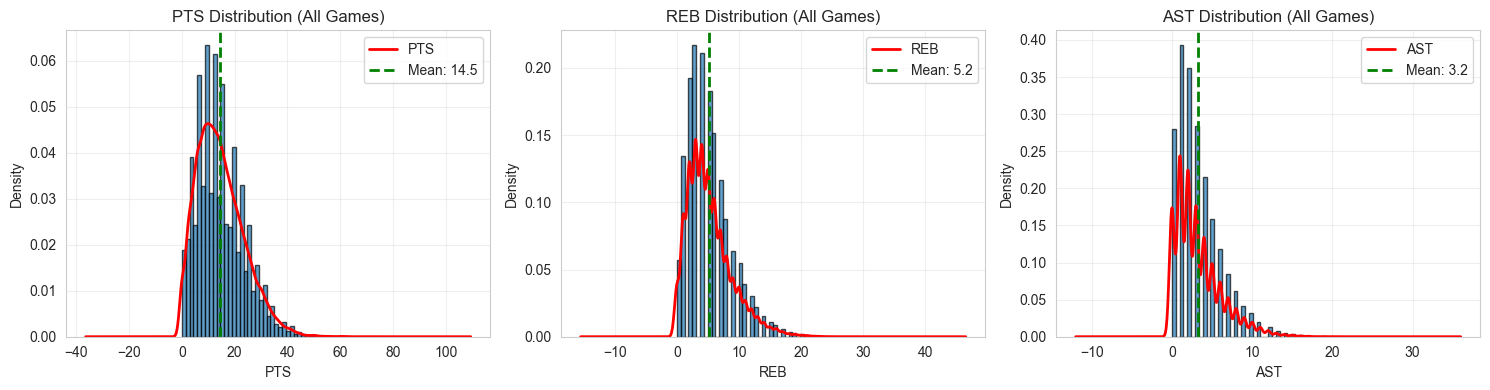


✓ Distribution analysis complete


In [3]:
# Analyze our target variables: PTS, REB, AST

print("TARGET VARIABLE STATISTICS")
print("=" * 60)

targets = ['PTS', 'REB', 'AST']
stats_df = df[targets].describe()
print(stats_df)

# Additional stats
print("\nAdditional Statistics:")
for target in targets:
  print(f"\n{target}:")
  print(f"  Median: {df[target].median():.1f}")
  print(f"  Mode: {df[target].mode().values[0]:.1f}")
  print(f"  Skewness: {df[target].skew():.2f}")
  print(f"  Kurtosis: {df[target].kurtosis():.2f}")

# Visualize distributions
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, target in enumerate(targets):
  ax = axes[idx]

  # Histogram with KDE
  ax.hist(df[target], bins=50, edgecolor='black', alpha=0.7, density=True)
  df[target].plot.kde(ax=ax, color='red', linewidth=2)

  # Add mean line
  mean_val = df[target].mean()
  ax.axvline(mean_val, color='green', linestyle='--', linewidth=2,
             label=f'Mean: {mean_val:.1f}')

  ax.set_xlabel(target)
  ax.set_ylabel('Density')
  ax.set_title(f'{target} Distribution (All Games)')
  ax.legend()
  ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Distribution analysis complete")

CORRELATION ANALYSIS

Top 5 correlations with each target:

PTS:
PTS    1.00
FGM    0.95
FGA    0.85
FTM    0.63
MIN    0.63
FTA    0.62
Name: PTS, dtype: float64

REB:
REB     1.00
DREB    0.93
OREB    0.66
MIN     0.37
FGM     0.31
BLK     0.29
Name: REB, dtype: float64

AST:
AST    1.00
MIN    0.44
FGA    0.41
PTS    0.37
TOV    0.36
FGM    0.34
Name: AST, dtype: float64



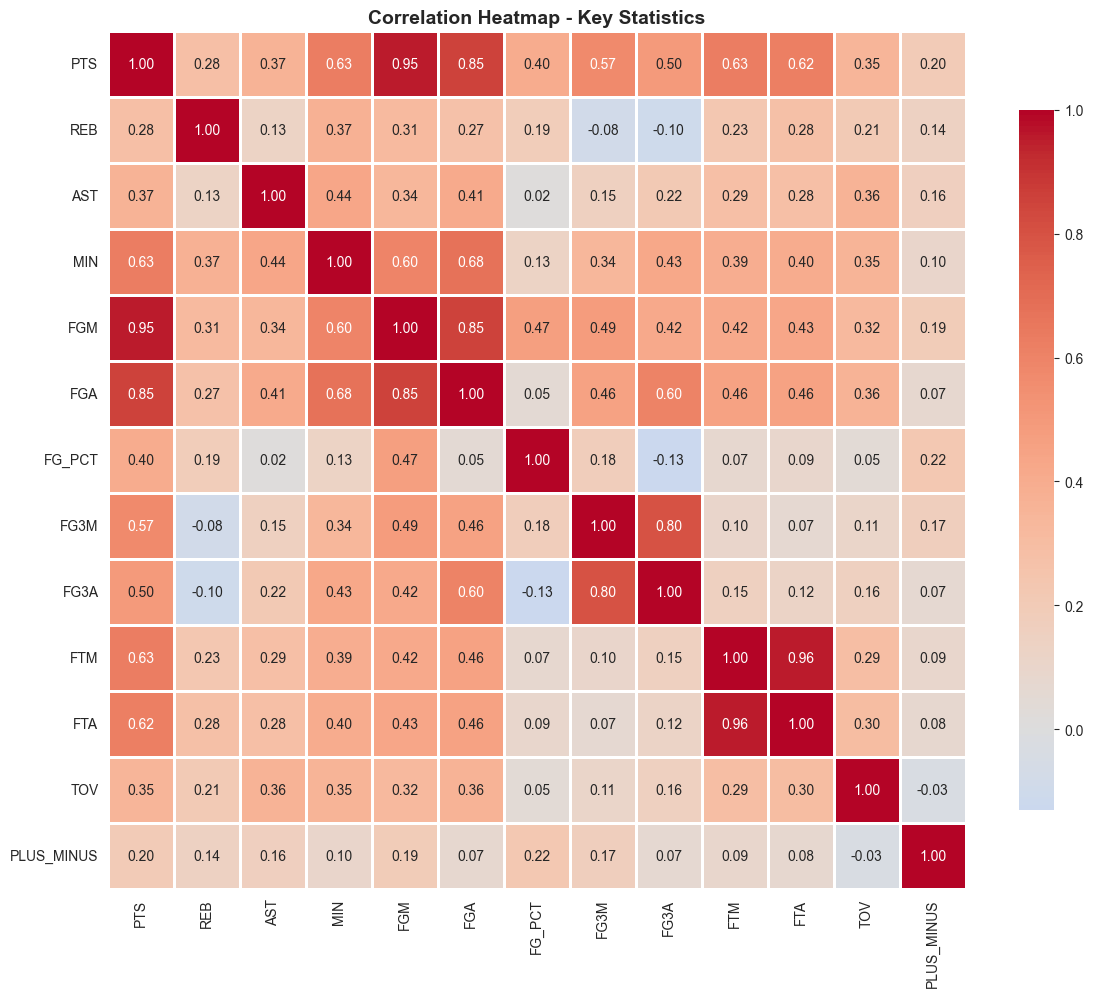

✓ Correlation analysis complete


In [4]:
# Check correlations between stats and our targets

print("CORRELATION ANALYSIS")
print("=" * 60)

# Select numeric columns
numeric_cols = ['MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT',
              'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB',
              'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PLUS_MINUS']

# Correlation with our targets
targets = ['PTS', 'REB', 'AST']

print("\nTop 5 correlations with each target:\n")
for target in targets:
  print(f"{target}:")
  corr = df[numeric_cols].corr()[target].sort_values(ascending=False)
  print(corr.head(6))  # Top 6 (including self-correlation)
  print()

# Correlation heatmap for key stats
fig, ax = plt.subplots(figsize=(12, 10))

key_stats = ['PTS', 'REB', 'AST', 'MIN', 'FGM', 'FGA', 'FG_PCT',
           'FG3M', 'FG3A', 'FTM', 'FTA', 'TOV', 'PLUS_MINUS']

corr_matrix = df[key_stats].corr()

sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm',
          center=0, square=True, linewidths=1, ax=ax,
          cbar_kws={"shrink": 0.8})

ax.set_title('Correlation Heatmap - Key Statistics', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("✓ Correlation analysis complete")

MINUTES PLAYED ANALYSIS

MIN statistics:
count    66409.00
mean        28.83
std          7.62
min          0.00
25%         24.00
50%         30.00
75%         35.00
max         57.00
Name: MIN, dtype: float64

MIN correlation with targets:
  MIN vs PTS: 0.626
  MIN vs REB: 0.370
  MIN vs AST: 0.435


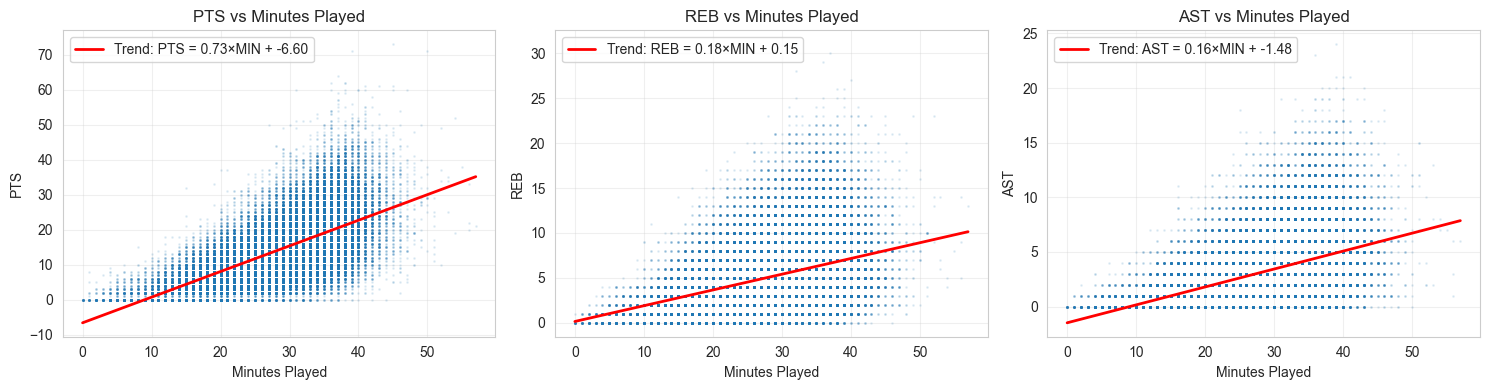


✓ Minutes analysis complete

Key Insight: More minutes = more stats (obvious but important!)
We can use MIN_last_5 as a feature (predicts opportunity)


In [5]:
# Minutes played - a KEY predictor (we CAN estimate this before game!)

print("MINUTES PLAYED ANALYSIS")
print("=" * 60)

# Minutes stats
print(f"\nMIN statistics:")
print(df['MIN'].describe())

# Correlation with targets
print(f"\nMIN correlation with targets:")
for target in ['PTS', 'REB', 'AST']:
  corr = df[['MIN', target]].corr().iloc[0, 1]
  print(f"  MIN vs {target}: {corr:.3f}")

# Scatter plots
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, target in enumerate(['PTS', 'REB', 'AST']):
  ax = axes[idx]

  # Scatter with trend line
  ax.scatter(df['MIN'], df[target], alpha=0.1, s=1)

  # Add trend line
  z = np.polyfit(df['MIN'].fillna(0), df[target], 1)
  p = np.poly1d(z)
  x_trend = np.linspace(df['MIN'].min(), df['MIN'].max(), 100)
  ax.plot(x_trend, p(x_trend), "r-", linewidth=2,
          label=f'Trend: {target} = {z[0]:.2f}×MIN + {z[1]:.2f}')

  ax.set_xlabel('Minutes Played')
  ax.set_ylabel(target)
  ax.set_title(f'{target} vs Minutes Played')
  ax.legend()
  ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Minutes analysis complete")
print("\nKey Insight: More minutes = more stats (obvious but important!)")
print("We can use MIN_last_5 as a feature (predicts opportunity)")

In [7]:
# BASELINE MODEL: 5-game rolling average
# This is what we need to BEAT!

print("CALCULATING BASELINE MODEL")
print("=" * 60)

# Create baseline predictions
# CRITICAL: shift(1) ensures we only use PAST games
df_baseline = df.copy()

targets = ['PTS', 'REB', 'AST']

for target in targets:
  # 5-game rolling average (shifted by 1 to prevent leakage)
  df_baseline[f'{target}_baseline'] = (
      df_baseline.groupby('Player_ID')[target]
      .shift(1)  # ← CRITICAL: Don't use current game!
      .rolling(5, min_periods=1)
      .mean()
  )

# Drop rows where we can't make predictions (first game per player)
df_baseline = df_baseline.dropna(subset=['PTS_baseline', 'REB_baseline', 'AST_baseline'])

print(f"\nGames with baseline predictions: {len(df_baseline):,}")
print(f"Games dropped (no history): {len(df) - len(df_baseline):,}")

# Calculate MAE for baseline
from sklearn.metrics import mean_absolute_error

print("\nBASELINE PERFORMANCE (5-game rolling average):")
print("-" * 60)

baseline_results = {}
for target in targets:
  actual = df_baseline[target]
  predicted = df_baseline[f'{target}_baseline']

  mae = mean_absolute_error(actual, predicted)
  baseline_results[target] = mae

  print(f"{target}:")
  print(f"  MAE: {mae:.3f}")
  print(f"  This is what we need to beat!")
  print()

# Show example predictions
print("Example predictions (first player, first 10 games):")
sample = df_baseline[df_baseline['Player_ID'] == df_baseline['Player_ID'].iloc[0]].head(10)
print(sample[['PLAYER_NAME', 'GAME_DATE', 'PTS', 'PTS_baseline', 'REB', 'REB_baseline', 'AST', 'AST_baseline']])

print("\n✓ Baseline model established!")
print(f"\nGoals to beat baseline:")
print(f"  PTS: {baseline_results['PTS']:.3f} → Target: {baseline_results['PTS'] * 0.90:.3f} (10% improvement)")
print(f"  REB: {baseline_results['REB']:.3f} → Target: {baseline_results['REB'] * 0.90:.3f} (10% improvement)")
print(f"  AST: {baseline_results['AST']:.3f} → Target: {baseline_results['AST'] * 0.90:.3f} (10% improvement)")

CALCULATING BASELINE MODEL

Games with baseline predictions: 66,408
Games dropped (no history): 1

BASELINE PERFORMANCE (5-game rolling average):
------------------------------------------------------------
PTS:
  MAE: 5.513
  This is what we need to beat!

REB:
  MAE: 2.175
  This is what we need to beat!

AST:
  MAE: 1.610
  This is what we need to beat!

Example predictions (first player, first 10 games):
     PLAYER_NAME  GAME_DATE  PTS  PTS_baseline  REB  REB_baseline  AST  \
1   LeBron James 2019-10-25   32         18.00    7         10.00   10   
2   LeBron James 2019-10-27   20         25.00    6          8.50   12   
3   LeBron James 2019-10-29   23         23.33    2          7.67    8   
4   LeBron James 2019-11-01   39         23.25   12          6.25   16   
5   LeBron James 2019-11-03   21         26.40   11          7.40   13   
6   LeBron James 2019-11-05   30         27.00   10          7.60   11   
7   LeBron James 2019-11-08   25         26.60    4          8.20    6

BASELINE ERROR ANALYSIS


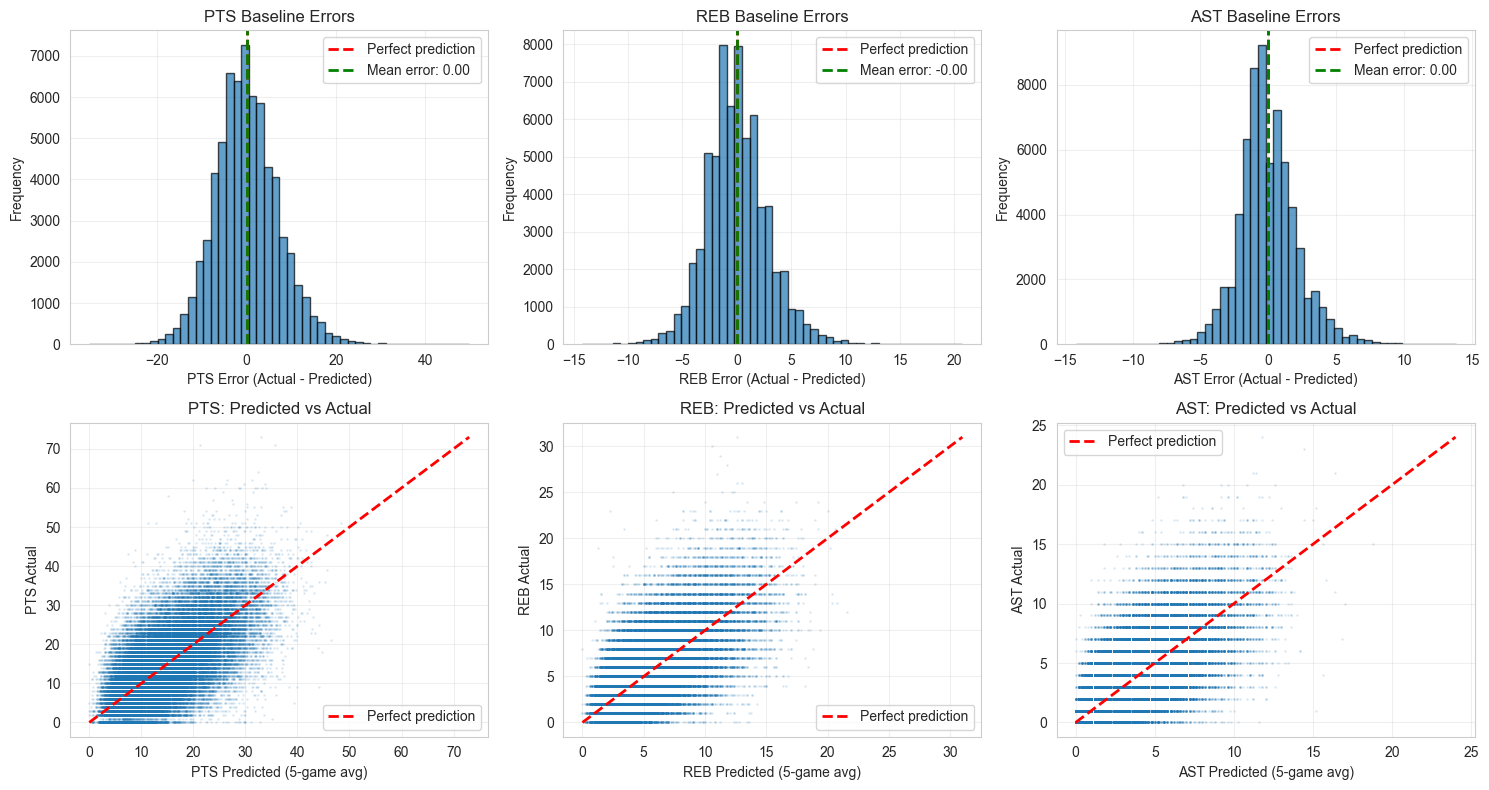


Where baseline struggles:
------------------------------------------------------------

PTS:
  Worst prediction: Predicted 21.2, Actual 71.0 (error: 49.8)
  MAE by minutes played:
    0-10 min: MAE 6.80 (1,061 games)
    10-20 min: MAE 4.81 (8,757 games)
    20-30 min: MAE 5.07 (25,808 games)
    30-40 min: MAE 5.91 (28,730 games)
    40+ min: MAE 7.84 (2,032 games)

REB:
  Worst prediction: Predicted 2.2, Actual 23.0 (error: 20.8)
  MAE by minutes played:
    0-10 min: MAE 2.74 (1,061 games)
    10-20 min: MAE 1.99 (8,757 games)
    20-30 min: MAE 2.07 (25,808 games)
    30-40 min: MAE 2.27 (28,730 games)
    40+ min: MAE 2.65 (2,032 games)

AST:
  Worst prediction: Predicted 15.2, Actual 1.0 (error: -14.2)
  MAE by minutes played:
    0-10 min: MAE 1.50 (1,061 games)
    10-20 min: MAE 1.27 (8,757 games)
    20-30 min: MAE 1.47 (25,808 games)
    30-40 min: MAE 1.80 (28,730 games)
    40+ min: MAE 2.23 (2,032 games)

✓ Error analysis complete


In [8]:
# Analyze baseline prediction errors

print("BASELINE ERROR ANALYSIS")
print("=" * 60)

# Calculate errors
for target in targets:
  df_baseline[f'{target}_error'] = df_baseline[target] - df_baseline[f'{target}_baseline']
  df_baseline[f'{target}_abs_error'] = df_baseline[f'{target}_error'].abs()

# Error distributions
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

for idx, target in enumerate(targets):
  # Top row: Error distribution
  ax1 = axes[0, idx]
  errors = df_baseline[f'{target}_error']

  ax1.hist(errors, bins=50, edgecolor='black', alpha=0.7)
  ax1.axvline(0, color='red', linestyle='--', linewidth=2, label='Perfect prediction')
  ax1.axvline(errors.mean(), color='green', linestyle='--', linewidth=2,
              label=f'Mean error: {errors.mean():.2f}')
  ax1.set_xlabel(f'{target} Error (Actual - Predicted)')
  ax1.set_ylabel('Frequency')
  ax1.set_title(f'{target} Baseline Errors')
  ax1.legend()
  ax1.grid(alpha=0.3)

  # Bottom row: Predicted vs Actual
  ax2 = axes[1, idx]
  ax2.scatter(df_baseline[f'{target}_baseline'], df_baseline[target],
              alpha=0.1, s=1)

  # Perfect prediction line
  min_val = min(df_baseline[f'{target}_baseline'].min(), df_baseline[target].min())
  max_val = max(df_baseline[f'{target}_baseline'].max(), df_baseline[target].max())
  ax2.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2,
           label='Perfect prediction')

  ax2.set_xlabel(f'{target} Predicted (5-game avg)')
  ax2.set_ylabel(f'{target} Actual')
  ax2.set_title(f'{target}: Predicted vs Actual')
  ax2.legend()
  ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Where does baseline fail most?
print("\nWhere baseline struggles:")
print("-" * 60)

for target in targets:
  print(f"\n{target}:")

  # High error games
  high_errors = df_baseline.nlargest(5, f'{target}_abs_error')
  print(f"  Worst prediction: Predicted {high_errors.iloc[0][f'{target}_baseline']:.1f}, "
        f"Actual {high_errors.iloc[0][target]:.1f} "
        f"(error: {high_errors.iloc[0][f'{target}_error']:.1f})")

  # Mean absolute error by playing time
  bins = [0, 10, 20, 30, 40, 60]
  labels = ['0-10', '10-20', '20-30', '30-40', '40+']
  df_baseline['MIN_bin'] = pd.cut(df_baseline['MIN'], bins=bins, labels=labels)

  print(f"  MAE by minutes played:")
  for bin_label in labels:
      subset = df_baseline[df_baseline['MIN_bin'] == bin_label]
      if len(subset) > 0:
          mae = subset[f'{target}_abs_error'].mean()
          print(f"    {bin_label} min: MAE {mae:.2f} ({len(subset):,} games)")

print("\n✓ Error analysis complete")